# Connecting

In [1]:
import openeo

#connect with VITO backend
vito = openeo.connect("https://openeo.vito.be")

In [2]:
vito.authenticate_basic("driesj","driesj123")
connection = vito 

In [3]:
gee = openeo.connect("https://earthengine.openeo.org/v1.0")
gee.authenticate_basic("group1", "test123")

<Connection to 'https://earthengine.openeo.org/v1.0' with BearerAuth>

In [4]:
from rasterio.io import MemoryFile
def plot_result(data):
    with MemoryFile(data) as memfile:
        with memfile.open() as dataset:
            data_array = dataset.read()
        from rasterio.plot import show,show_hist
        import matplotlib.pyplot as plt
        fig, (l, r) = plt.subplots(1, 2,figsize=(12, 5))
        
        show(data_array,cmap='YlGn',ax=l)
        show_hist(data_array,ax=r)

## Retrieving results as image

In [5]:
s2_fapar = connection.load_collection("TERRASCOPE_S2_FAPAR_V2",
            spatial_extent={'west':16.138916,'east':16.524124,'south':48.1386,'north':48.320647},
            temporal_extent=["2020-05-01","2020-05-20"] )

#specify process graph
fapar_composite = s2_fapar.max_time()
%time geotiff_bytes = fapar_composite.download(format="GTiff")

CPU times: user 74.9 ms, sys: 54.2 ms, total: 129 ms
Wall time: 28.5 s


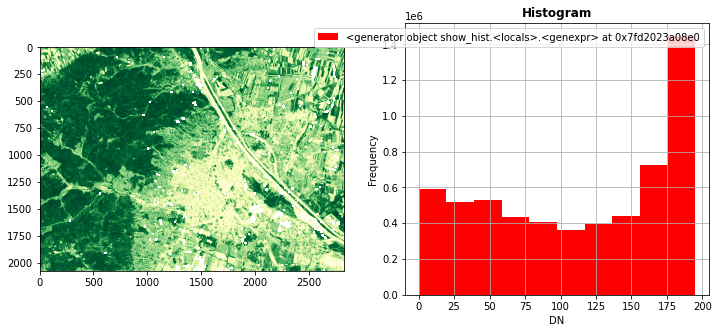

In [6]:
plot_result(geotiff_bytes)

## Retrieving results as timeseries

CPU times: user 7.38 ms, sys: 1.92 ms, total: 9.31 ms
Wall time: 12.8 s


<AxesSubplot:title={'center':'openEO NDVI with clouds'}, xlabel='date'>

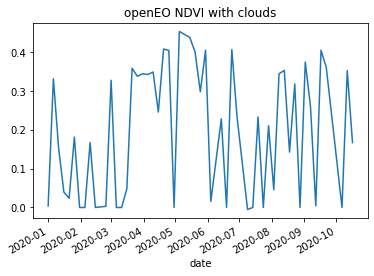

In [7]:
import shapely
from openeo.rest.conversions import timeseries_json_to_pandas
import pandas as pd


polygon = shapely.geometry.Polygon([(3.71, 51.01), (3.72, 51.02), (3.73, 51.01)])
bbox = polygon.bounds

%time timeseries_dict = connection.load_collection("TERRASCOPE_S2_TOC_V2",\
                            temporal_extent = ["2020-01-01", "2020-12-10"],\
                            spatial_extent=dict(zip(["west", "south", "east", "north"], bbox)),\
                            bands=["TOC-B04_10M","TOC-B08_10M"])\
                            .ndvi()\
                            .polygonal_mean_timeseries(polygon)\
                            .execute()

dataframe = timeseries_json_to_pandas(timeseries_dict)
dataframe.index = pd.to_datetime(dataframe.index)
dataframe.dropna().plot(title='openEO NDVI with clouds')

## SAR processing

In [8]:
from openeo.processes import log,multiply,ln,divide

# Connect to backend via basic authentication

collection_gee = "COPERNICUS/S1_GRD"
collection_vito = "S1_GRD_SIGMA0_ASCENDING"

con = vito

def sar_difference(connection,collection, to_decibel=True):
    datacube = connection.load_collection(collection,
                                   spatial_extent={"west": 4.115846, "south": 51.209657, "east": 4.670906,
                                                   "north": 51.721780},
                                   temporal_extent=["2019-03-01", "2019-03-15"],
                                   bands=["VV", "VH"])
    mean = datacube.mean_time()
    if to_decibel:
        mean = mean.apply(lambda cube:multiply(10.0,divide(ln(cube),ln(10))))

    difference = mean.reduce_dimension(dimension="bands", reducer=lambda cube: cube.array_element(1) - cube.array_element(0))
    return difference


%time sar_difference(gee,collection_gee,to_decibel=False).download("sar-sigma0-rgb-scaled-gee.tiff",format='GTIFF-THUMB',options={'size':2500,'epsgCode':32631})
%time sar_difference(vito,collection_vito,to_decibel=True).download("sar-sigma0-rgb-scaled-vito.tiff",format='GTIFF',options={'ZLEVEL':6,'tiled':True})

CPU times: user 267 ms, sys: 119 ms, total: 386 ms
Wall time: 17.6 s
CPU times: user 579 ms, sys: 375 ms, total: 954 ms
Wall time: 39.1 s


In [9]:
!gdalinfo sar-sigma0-rgb-scaled-gee.tiff

Driver: GTiff/GeoTIFF
Files: sar-sigma0-rgb-scaled-gee.tiff
Size is 1624, 2500
Coordinate System is:
PROJCS["WGS 84 / UTM zone 31N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",3],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32631"]]
Origin = (577943.459215519251302,5731415.795868769288063)
Pixel Size = (23.073686244085362,-23.073686244085430)
Metadata:
  AREA_OR_P

In [10]:
!gdalinfo sar-sigma0-rgb-scaled-vito.tiff

Driver: GTiff/GeoTIFF
Files: sar-sigma0-rgb-scaled-vito.tiff
Size is 3748, 5770
Coordinate System is:
PROJCS["WGS 84 / UTM zone 31N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",3],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32631"]]
Origin = (577940.000000000000000,5731425.182499999180436)
Pixel Size = (10.000000000000000,-10.000000000000000)
Metadata:
  AREA_OR_